# Stylometric analysis of the Malmi -- Nakamoto emails

In [ ]:
# imports 

import nltk
nltk.download('averaged_perceptron_tagger_eng')
from nltk.probability import FreqDist
from nltk.util import ngrams
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join, split
from string import punctuation


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# this assumes that the rt module folder is in the same directory as this notebook
import radialtree as rt

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/raisaneh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
"""Read files"""
# quotes have been removed already

# paths to the directories that contain the emails
dir1 = "Malmi/"
dir2 = "Nakamoto/"

malmi_files = [join(dir1,f) for f in listdir(dir1) if isfile(join(dir1, f))]
naka_files = [join(dir2, f) for f in listdir(dir2) if isfile(join(dir2, f))]

# create a list of the filenames in a specific order, to be used as labels in plotting
filenames_ordered = [split(x)[1] for x in malmi_files] + [split(x)[1] for x in naka_files]

# raw text strings
malmi_text = ""
nakamoto_text = ""

# dicts. key: filename, value: word-tokenized message
malmi_emails = {}
nakamoto_emails = {}

for file in malmi_files:
    with open(file) as f:
        x = f.read()
        # check if the email contains full sentences
        tokens = nltk.word_tokenize(x)
        punct = 0
        for i in tokens:
            if i in punctuation:
                punct += 1
        if punct == 0:
            # if no full sentences, remove the email 
            filenames_ordered.remove(split(file)[1])
            continue
        malmi_text += x + " "
        malmi_emails[split(file)[1]] = nltk.word_tokenize(x)

for file in naka_files:
    with open(file) as f:
        x = f.read()
        # check if the email contains full sentences
        tokens = nltk.word_tokenize(x)
        punct = 0
        for i in tokens:
            if i in punctuation:
                punct += 1
        # if no full sentences, remove the email 
        if punct == 0: 
            filenames_ordered.remove(split(file)[1])
            continue
        nakamoto_text += x + " "
        nakamoto_emails[split(file)[1]] = nltk.word_tokenize(x)

print(len(malmi_text), len(nakamoto_text))


41507 125181


In [33]:
"""Define functions for different features"""

def word_tokenize_sans_punct(sentences):
    # nltk.word_tokenize counts each punctuation mark as a word, except for in abbreviations like e.g.
    # it also separates contractions into two words
    """Turn sentence-tokenized text into word-tokenized,
    without the punctuation marks.
    In: sentence-tokenized text
    Out: word-tokenized text"""
    return [[w for w in nltk.word_tokenize(s) if w not in punctuation] for s in sentences]

def flatten(array):
    """Flatten a 2d list into 1d"""
    return sum(array, [])

def word_lens(sentences):
    """Turn a list of sentences into a list of lengths of each
    word in each sentence, disregarding sentence borders."""
    text = word_tokenize_sans_punct(sentences)
    text = flatten(text)
    return [len(w) for w in text]

def avg_word_length(text):
    """Count the average n of chars in a word in the text.
    In: sentence-tokenized text
    Out: the average lenght of a word in the text"""
    lens = word_lens(text)
    return sum(lens) / len(lens)


def sentence_lens(sentences):
    """Turn a list of sentences into a list of their lenghts.
    Excluding punctuation."""
    return [len(w) for w in word_tokenize_sans_punct(sentences)]

def avg_sentence_length(sentences):
    """Count words in sentences, ignoring punctuation marks.
    In: sentence-tokenized text
    Out: the average length of a sentence in the text"""

    lens = sentence_lens(sentences)
    return sum(lens) / len(lens)


def type_token_ratio(text):
    """calculate number of unique words per word-tokenized text
    divide by num. of all words. The words are lowercased.
    Should take equal size samples for normalized comparison."""
    text = word_tokenize_sans_punct(text)
    text = [w.lower() for w in flatten(text)]
    n_all_words = len(text)
    unique = len(set(text))
    return unique/n_all_words

def word_frequencies(text, title):
    """Count the n of occurrences of each word that appears in
    the text. Including punctuation, lowercased.
    In: sentence-tokenized text
    Out:"""
    text = [nltk.word_tokenize(s) for s in text]
    text = [w.lower() for w in flatten(text)]
    fdist = FreqDist(text)

    # normalize by dividing by the total word count
    total_words = float(fdist.N())
    for word in fdist:
        fdist[word] /= total_words

    fdist.plot(20, title=title)
    plt.show()

    return fdist.most_common(20)

def word_length_distribution(sents_a:list, sents_b:list, title):
    """Plot a word lengths distribution for a list of sentences.
    'a' should be Malmi and 'b' Nakamoto."""
    lens_a = word_lens(sents_a)
    lens_b = word_lens(sents_b)
    
    plt.boxplot([lens_a, lens_b], tick_labels=["Malmi", "Nakamoto"])
    plt.title(title)
    plt.show()
    return

def sentence_length_distribution(sents_a, sents_b, title):
    """Same as word_length_distribution but for sents"""
    lens_a = sentence_lens(sents_a)
    lens_b = sentence_lens(sents_b)

    plt.boxplot([lens_a, lens_b], tick_labels=["Malmi", "Nakamoto"])
    plt.title(title)
    plt.show()
    return


def char_ngrams(texta: str, labela: str, textb: str, labelb: str, n, title):
    """
    In: string containing all the text, including whitespace
    Should exclude whitespace since reading the data already modifies the whitespaces found???
    Out: ?"""
    # remove line breaks, IDK if this is good
    n_grams_a = [''.join(g).replace(" ", "_").replace("\n", "<ln>") for g in ngrams(texta, n)]
    fdist_a = FreqDist(n_grams_a)
    n_grams_b = [''.join(g).replace(" ", "_").replace("\n", "<ln>") for g in ngrams(textb, n)]
    fdist_b = FreqDist(n_grams_b)

    # normalize by dividing by the total ngram count
    total = float(fdist_a.N())
    for gram in fdist_a:
        fdist_a[gram] /= total
    
    total = float(fdist_b.N())
    for gram in fdist_b:
        fdist_b[gram] /= total
    
    ax = plt.gca()
    ax.grid(True, color="silver")
    x = [val for _, val in fdist_a.most_common(20)]
    lab = [i for i, _ in fdist_a.most_common(20)]
    y = [fdist_b.get(l) for l in lab]
    ax.plot(x, label=labela)
    ax.plot(y, label=labelb)
    ax.legend()
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(lab)
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("N-grams")
    ax.set_ylabel("Frequency")
    plt.title(title)
    plt.show()

    return


def word_ngrams(sentencesa:list, labela:str, sentencesb:list, labelb:str, n, title):
    """Plot word n-gram frequency plot from lists of sentences.""" 
    texta = flatten([nltk.word_tokenize(s) for s in sentencesa])
    n_gramsa = ngrams(texta, n)
    fdist_a = FreqDist(n_gramsa)
    textb = flatten([nltk.word_tokenize(s) for s in sentencesb])
    n_gramsb = ngrams(textb, n)
    fdist_b = FreqDist(n_gramsb)

    # normalize by dividing by the total ngram count
    total_a = float(fdist_a.N())
    for gram in fdist_a:
        fdist_a[gram] /= total_a
    
    total_b = float(fdist_b.N())
    for gram in fdist_b:
        fdist_b[gram] /= total_b
    
    ax = plt.gca()
    ax.grid(True, color="silver")
    x = [val for _, val in fdist_a.most_common(20)]
    lab = [i for i, _ in fdist_a.most_common(20)]
    y = [fdist_b.get(l) for l in lab]
    ax.plot(x, label=labela)
    ax.plot(y, label=labelb)
    ax.legend()
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(lab)
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("N-grams")
    ax.set_ylabel("Frequency")
    plt.title(title)
    plt.show()

    return


In [ ]:
"""More functions to help with manual analysis(?)"""

def disjoint_words(text1, text2):
    """From two text samples, find the symmetric difference between the
    sets of words from each sample. I.e. words that are not shared.
    Capitalization and punctuation are preserved.
    In: two lists of sentences
    Out: two sets of words, one for each input list"""
    words1 = set(flatten([nltk.word_tokenize(s) for s in text1]))
    words2 = set(flatten([nltk.word_tokenize(s) for s in text2]))

    unique1 = words1 - words2
    unique2 = words2 - words1

    return unique1, unique2


lens  473 473 41507 125181
avg. word length. Malmi, Nakamoto  4.5549068668334725 4.54921490508554
TTR. Malmi, Nakamoto 0.22518765638031693 0.220412467775955


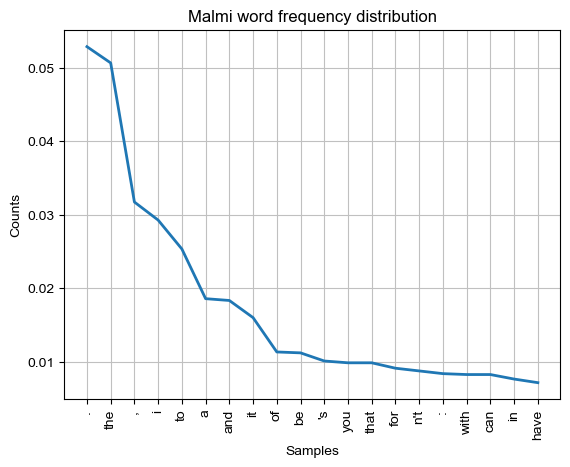

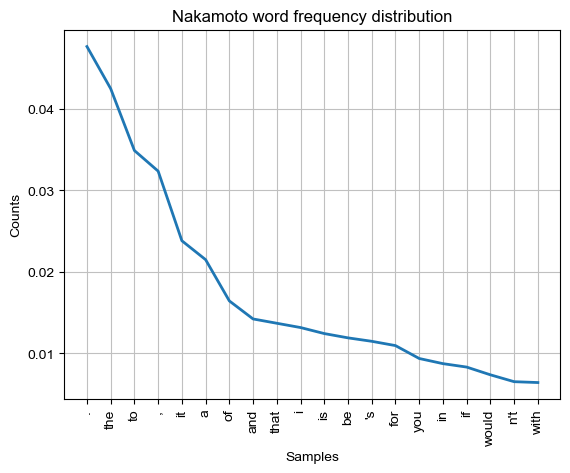

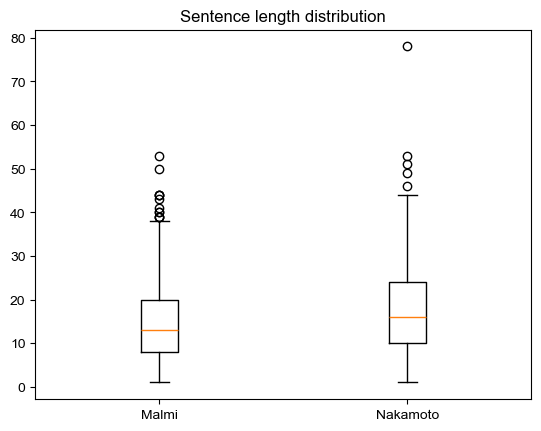

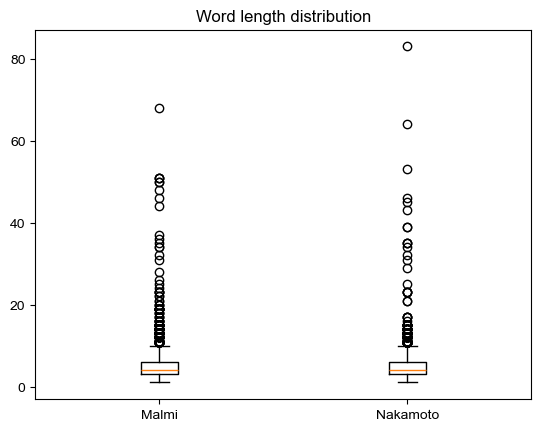

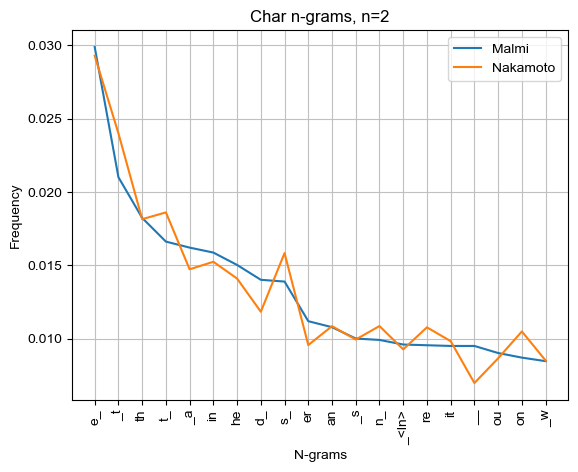

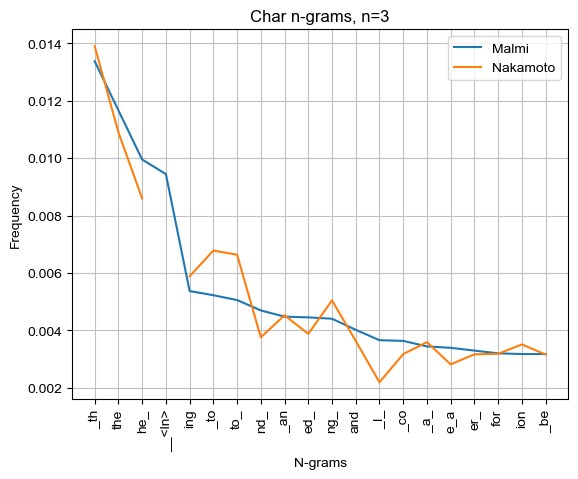

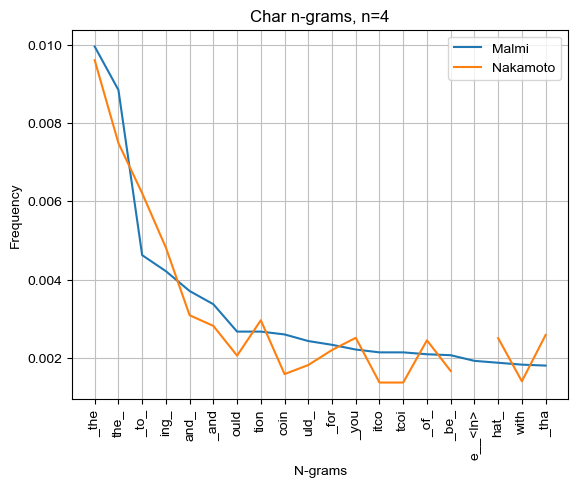

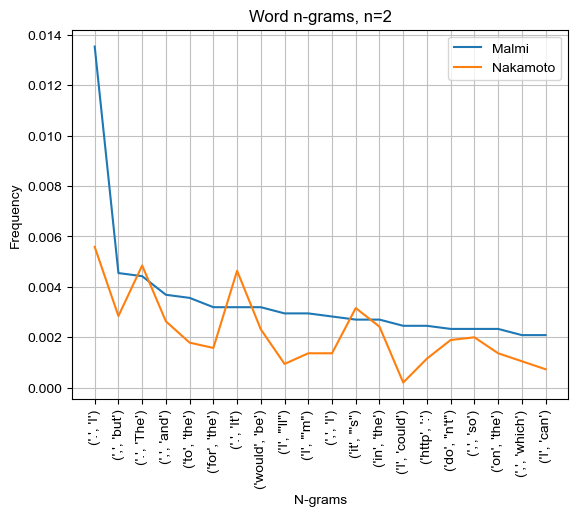

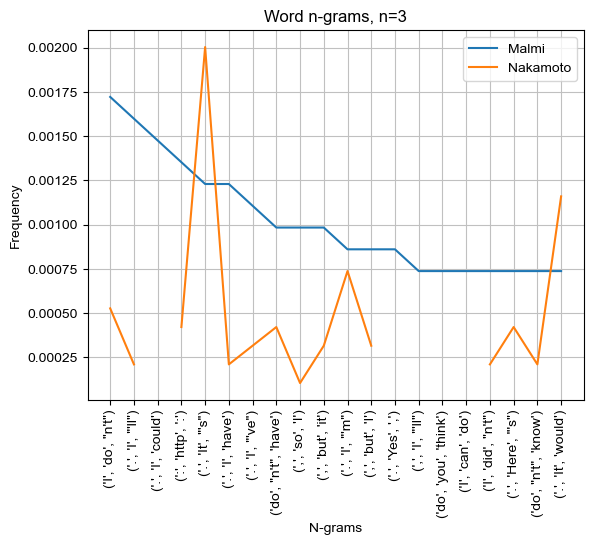

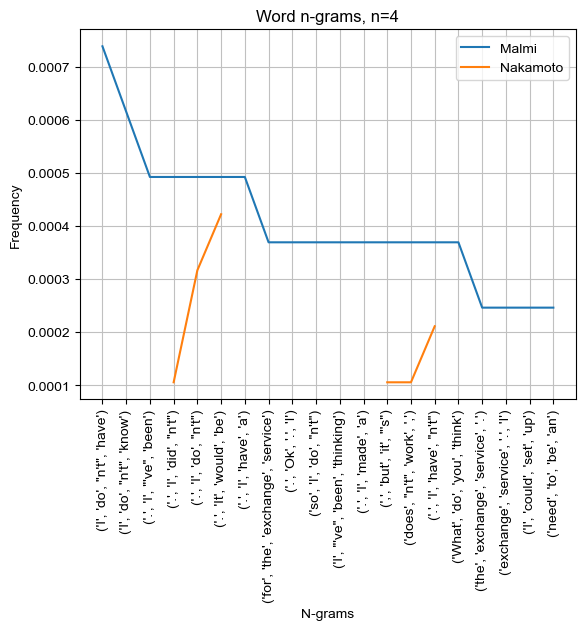

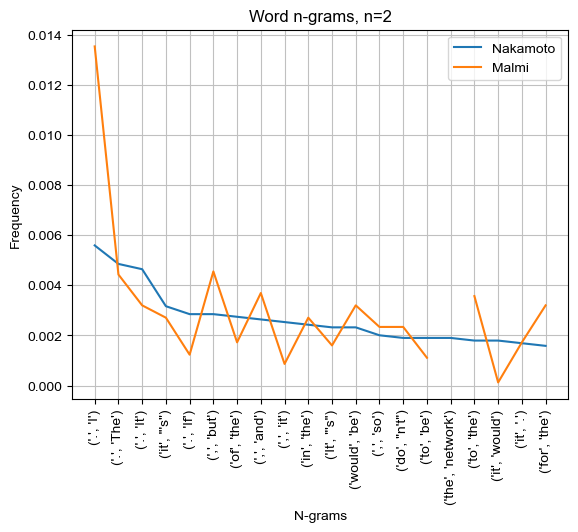

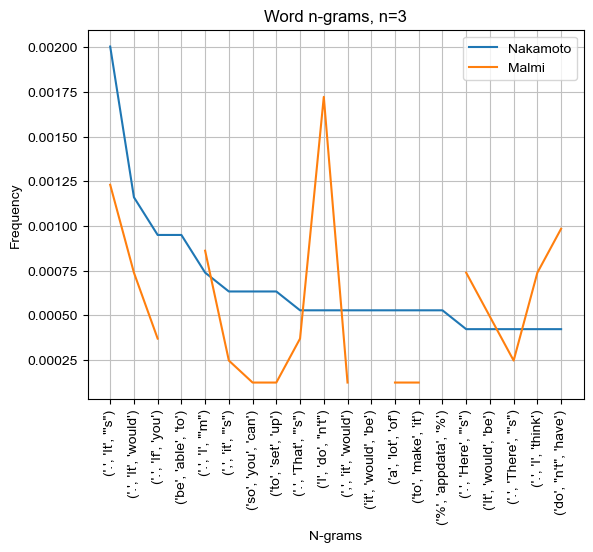

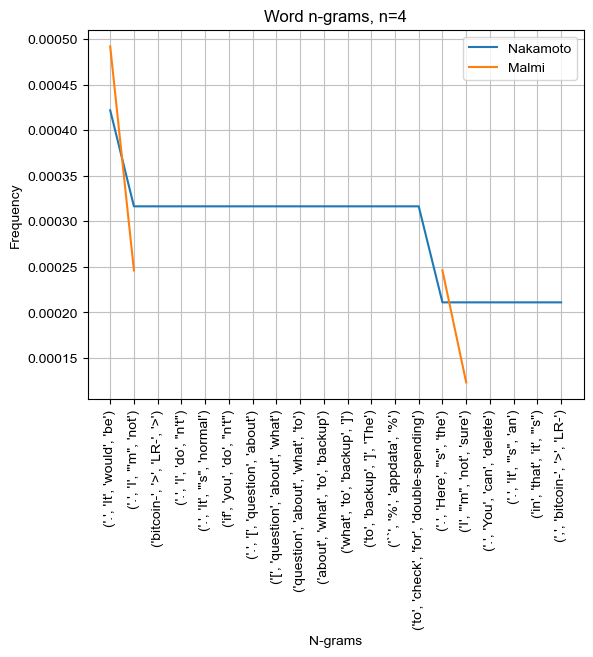

btw
panel
SOCKS
Ubuntu
listed
bitcoin.org/zh-hans
infinity
revision
font
contacts
20statistics
Simple
domains
Life
resources
environment
somebody
true
liquidity
founded
adopt
date
Take
via
320MB
//newlibertystandard.wetpaint.com/
filesize
PGP
cloud
removal
Drop
replacing
premature
wx
png
coincidentally
law
fields
Among
waypoint
//apps.sourceforge.net/trac/sourceforge/ticket/300
proxy
VPS
functionality
About
Have
Classes
title=Special
20for
svn
Small-scale
wide
zero
TCP/IP
net.cpp
touch
bitcoind
Second
faq
shown
errors
international
versa
familiarizing
-blockamount
windows-only-functions
compiling
Area
CMS'es
established
plus
connect-button
upscaled
posts
php
customize
tough
/oldsite
integration
standards
t=26954
promoted
among
Ok.
rewards
Great
contacting
20of
//apps.sourceforge.net/trac/sourceforge/wiki/Custom
crashed
artists
//cooltext.com/
warning
considered
plugins
highly
SEPA
//forum.bitcoin.org/
providers
ServiceProxy
automatic
slogan
responded
Finland
coding
back-end
lighttpd
pr

In [ ]:
"""Get features"""
# notice that for some features you need to take equal lenght samples

# taking equal number of sentences, n of chars and words will hopefully not be too different
sentences_malmi = nltk.sent_tokenize(malmi_text)
sentences_nakamoto = nltk.sent_tokenize(nakamoto_text)[0:len(sentences_malmi)]

print("lens ", len(sentences_malmi), len(sentences_nakamoto), len(malmi_text), len(nakamoto_text))
print("avg. word length. Malmi, Nakamoto ", avg_word_length(sentences_malmi), avg_word_length(sentences_nakamoto))
print("TTR. Malmi, Nakamoto", type_token_ratio(sentences_malmi), type_token_ratio(sentences_nakamoto))
word_frequencies(sentences_malmi, "Malmi word frequency distribution"), word_frequencies(sentences_nakamoto, "Nakamoto word frequency distribution")
sentence_length_distribution(sentences_malmi, sentences_nakamoto, "Sentence length distribution")
word_length_distribution(sentences_malmi, sentences_nakamoto, "Word length distribution")
# char ngram distribution is normalized so it hopefully won't matter that the texts are of different length

char_ngrams(malmi_text, "Malmi", nakamoto_text, "Nakamoto", 2, "Char n-grams, n=2")
char_ngrams(malmi_text, "Malmi", nakamoto_text, "Nakamoto", 3, "Char n-grams, n=3")
char_ngrams(malmi_text, "Malmi", nakamoto_text, "Nakamoto", 4, "Char n-grams, n=4")


word_ngrams(sentences_malmi, "Malmi", sentences_nakamoto, "Nakamoto", 2, "Word n-grams, n=2")
word_ngrams(sentences_malmi, "Malmi", sentences_nakamoto, "Nakamoto", 3, "Word n-grams, n=3")
word_ngrams(sentences_malmi, "Malmi", sentences_nakamoto, "Nakamoto", 4, "Word n-grams, n=4")
word_ngrams(sentences_nakamoto, "Nakamoto", sentences_malmi, "Malmi", 2, "Word n-grams, n=2")
word_ngrams(sentences_nakamoto, "Nakamoto", sentences_malmi, "Malmi", 3, "Word n-grams, n=3")
word_ngrams(sentences_nakamoto, "Nakamoto", sentences_malmi, "Malmi", 4, "Word n-grams, n=4")

m,n = disjoint_words(sentences_malmi, sentences_nakamoto)
for x in m:
    print(x)
print("\n\n\n")
for x in n:
    print(x)


In [19]:
"""ngrams"""

def features_vector(ngrams, features):
    # create a binary vector that signals the presence of all found ngrams
    # vector[0] is 1 if ngram[0] appears in the text, otherwise it's 0
    result = []
    for f in features:
        if f in ngrams:
            result.append(1)
        else:
            result.append(0)
    return np.array(result)

n2g = {}
n3g = {}

for key,email in malmi_emails.items():
    n2g[key] = list(ngrams(email, 2))
    n3g[key] = list(ngrams(email, 3))

for key,email in nakamoto_emails.items():
    n2g[key] = list(ngrams(email, 2))
    n3g[key] = list(ngrams(email, 3))

for x in ["mm7.txt", "mm9.txt", "mm27.txt", "mm55.txt", "mm90.txt", "mm101.txt", "mm110.txt", "mm59.txt", "mm114.txt", "sn112.txt"]:
    n3g.pop(x)

#2-grams list
list_2g = flatten([email for key,email in n2g.items()])

fdist_2 = FreqDist(list_2g)

# drop the ngrams that appear only once
hapaxes = fdist_2.hapaxes()
for x in hapaxes:
    fdist_2.pop(x)


# 2-gram features
features_2g = list(fdist_2.keys())
print("n of features ", len(features_2g))


# create bit vectors for features for each of the emails, to compute Jaccard distance
vectors_2g = {}
for id in filenames_ordered:
    vectors_2g[id] = features_vector(n2g[id], features_2g)
vec_2g_list = pd.DataFrame(data=vectors_2g).T

# number of emails analyzed
files_n = len(filenames_ordered)


n of features  3929


In [20]:
# 3-grams

all_3g = [email for key,email in n3g.items()]
all_3g = flatten(all_3g)

fdist_3 = FreqDist(all_3g)

# drop the ngrams that appear only once
hapaxes = fdist_3.hapaxes()
for x in hapaxes:
    fdist_3.pop(x)


features_3g = list(fdist_3.keys())

vectors_3g = {}
for id in filenames_ordered:
    try:
        vectors_3g[id] = features_vector(n3g[id], features_3g)
    except KeyError:
        continue
vec_3g_list = pd.DataFrame(data=vectors_3g).T


linkage ok
0.15000000000000002
1.1500000000000001
[[0.  0.  0.  1. ]
 [0.8 0.8 0.8 1. ]]


/home/raisaneh/anaconda3/envs/compsemenv/lib/python3.12/site-packages/radialtree.py:441: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


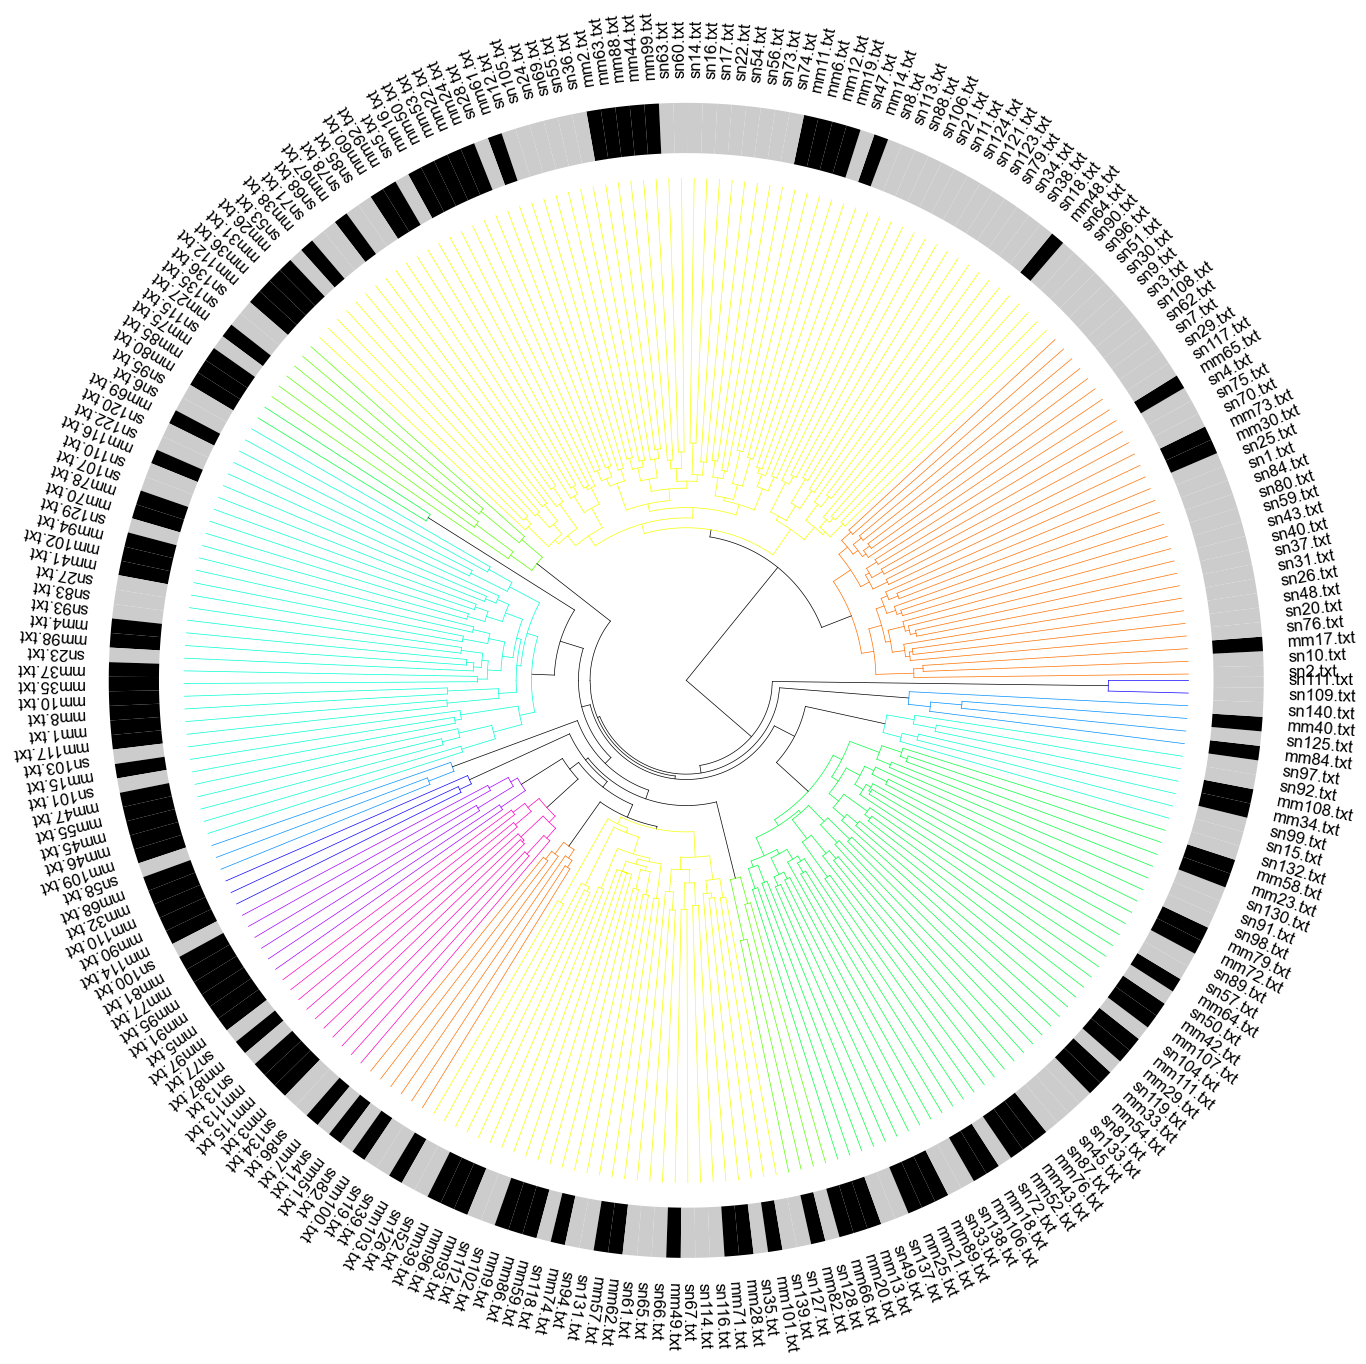

In [21]:
"""Plot dendrogram for word 2-grams"""

labels=filenames_ordered
condenced_distance_matrix = pdist(X=vec_2g_list, metric='jaccard')

Y = linkage(condenced_distance_matrix, method='ward', optimal_ordering=True)
print("linkage ok")
Z2 = dendrogram(Y,labels=labels,no_plot=True)
sample_classes={"example_color": ["M" if x[0] == "m" else "N" for x in filenames_ordered]}
rt.plot(Z2, figsize=[15,15], fontsize=12, sample_classes=sample_classes)


linkage ok
0.15000000000000002
1.1500000000000001
[[0.  0.  0.  1. ]
 [0.8 0.8 0.8 1. ]]


/home/raisaneh/anaconda3/envs/compsemenv/lib/python3.12/site-packages/radialtree.py:441: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


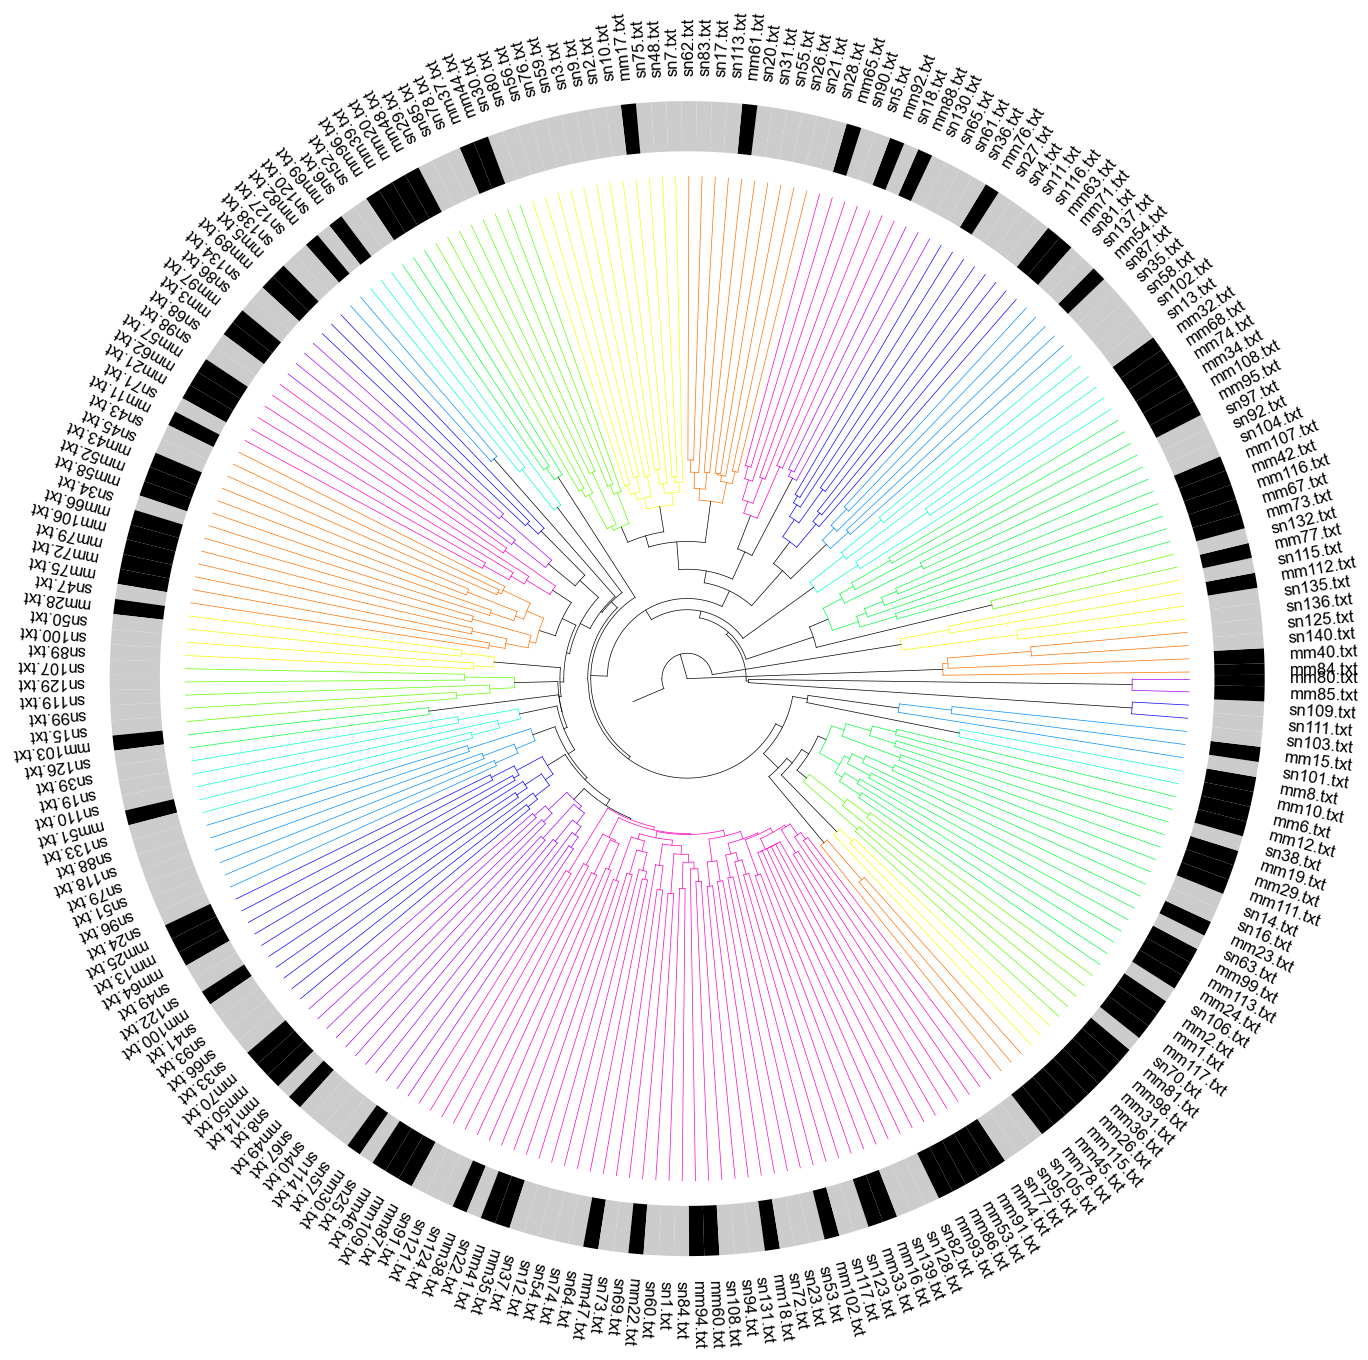

In [36]:
"""Plot dendrogram for word 3-grams"""

labels=vec_3g_list.index
condenced_distance_matrix_3g = pdist(X=vec_3g_list, metric='jaccard')

Y = linkage(condenced_distance_matrix_3g, method='ward', optimal_ordering=False)
print("linkage ok")
Z2 = dendrogram(Y,labels=labels,no_plot=True)
type_num=6
#type_list=["ex"+str(i) for i in range(type_num)]
#sample_classes={"example_color": [np.random.choice(type_list) for i in range(files_n)]}
sample_classes={"example_color": ["M" if x[0] == "m" else "N" for x in labels]}
rt.plot(Z2, figsize=[15,15], fontsize=12, sample_classes=sample_classes)
